In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

### RNN Training

In this notebook, we will explore a new way to train our algorithm in the hope of having better results. Instead of using $x_{\text{True}}(t-1)$ to predict $x(t)$, we will use $x_{\text{True}}(t-1)$ to predict $x(t)$, and $x(t+1)$ ... all the way to $x(t+N)$. Let's begin by importing our functions:

In [4]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    sigma : Function
        Activation function (sigmoid if unspecified)
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

In [5]:
def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    sigma : function
        Non-linearities (sigmoid if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

In [6]:
def quality(n_neuron, true, train, num_max=1):
    '''
    Plot and identify the quality of the training
    ---------------------
    n_neuron : int
        Number of neurons in our system
    true : ndarray
        True value of our model
    train : ndarray
        Train model
    num_max : int
        Number of neurons with the worst loss function
    '''
    MSE_total = []

    for i in range(n_neuron):
        MSE = np.mean((train[:,i] - true[:,i])**2)
        MSE_total.append(MSE)

    plt.plot(np.linspace(1, n_neuron, n_neuron), MSE_total, "-")
    plt.xlabel("neuron")
    plt.ylabel("loss")
    plt.ylim([0,1])
    plt.show()

    worst = []

    for i, neuron in enumerate((sorted(MSE_total)[::-1])):
        if i < num_max:
            worst.append(MSE_total.index(neuron))

    return worst

In [7]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

Here, we begin by generating all of the predicted value from the initial theoretical value. Then, we compare then entire prediction to the target and backpropagate.

In [112]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)

    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    #dt = nn.Parameter(dt)
    #mu = nn.Parameter(mu)
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    #optimizer = HessianFree(model.parameters())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass

        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC
        #x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        #x_pred[1:] = x_pred_temp.T

        x_pred[1] = model(x[0])  #Find x_pred at time (t+1)

        for i in range(x.shape[0] - 2):
            with torch.no_grad():
                x_pred_temp = x_pred[i+1].clone()
            x_pred[i+2] = model(x_pred_temp)

        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #if 4*epoch < n_iters:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
        #else:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=4*lr, momentum=0.8)

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 1 == 0:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

In [7]:
def learn_rate(epoch, a, b):
    #format a*np.exp(b*epoch)
    return a * np.exp(b * epoch)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN_AdaptLR(n_neurons, x, dt, mu, n_iters=500, verbose=False, loss_graph=False, a=0.01, b=0.0055, g=1, momentum=0.9):
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = g*torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify

    Learning_rates = []
    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):

        model = RNNModel(W=W, dt=dt, mu=mu)
        lr = learn_rate(epoch, a, b)
        Learning_rates.append(lr)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        loss = nn.MSELoss()


        #Forward pass

        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC
        #x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        #x_pred[1:] = x_pred_temp.T

        x_pred[1] = model(x[0])  #Find x_pred at time (t+1)

        for i in range(x.shape[0] - 2):
            with torch.no_grad():
                x_pred_temp = x[i+1]

            x_pred[i+2] = model(x_pred_temp)

        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 1 == 0:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = Learning_rates
    out["params"]["loss"] = Total_loss
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"


    if loss_graph:
        plt.plot(Learning_rates, Total_loss, "r-")
        plt.xlabel("learning rate (log)")
        plt.ylabel("loss")
        plt.xscale("log")
        plt.title(f"learning rate when working with {n_neurons} neurons")
        plt.show()
    
    return out

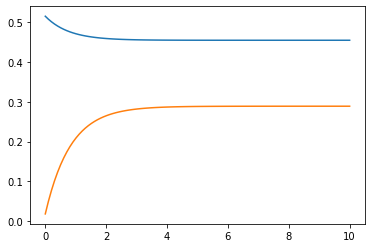

In [113]:
W = np.random.randn(2, 2)
IC = np.random.rand(2)

data = GenerateData(n_data=50, time=10, IC=IC, W=W, ratio=1)

t = np.linspace(0, 10, 100)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=W)[0])
plt.show()

epoch 0/200 loss 0.004319 pVar -1.231
epoch 1/200 loss 0.000034 pVar 0.978
epoch 2/200 loss 0.000569 pVar 0.631
epoch 3/200 loss 0.000123 pVar 0.922
epoch 4/200 loss 0.000043 pVar 0.974
epoch 5/200 loss 0.000064 pVar 0.961
epoch 6/200 loss 0.000010 pVar 0.994
epoch 7/200 loss 0.000009 pVar 0.994
epoch 8/200 loss 0.000007 pVar 0.996
epoch 9/200 loss 0.000006 pVar 0.996
epoch 10/200 loss 0.000007 pVar 0.996
epoch 11/200 loss 0.000006 pVar 0.996
epoch 12/200 loss 0.000006 pVar 0.997
epoch 13/200 loss 0.000006 pVar 0.997
epoch 14/200 loss 0.000006 pVar 0.997
epoch 15/200 loss 0.000006 pVar 0.997
epoch 16/200 loss 0.000006 pVar 0.997
epoch 17/200 loss 0.000005 pVar 0.997
epoch 18/200 loss 0.000005 pVar 0.997
epoch 19/200 loss 0.000005 pVar 0.997
epoch 20/200 loss 0.000005 pVar 0.997
epoch 21/200 loss 0.000005 pVar 0.997
epoch 22/200 loss 0.000005 pVar 0.997
epoch 23/200 loss 0.000005 pVar 0.997
epoch 24/200 loss 0.000005 pVar 0.997
epoch 25/200 loss 0.000005 pVar 0.997
epoch 26/200 loss 0.0

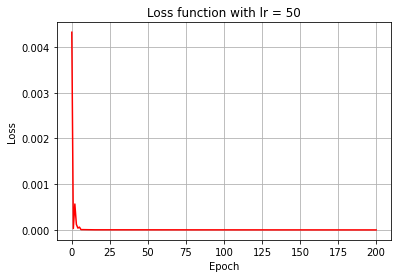

In [114]:
pred = Train_RNN(n_neurons=2, x=data["Data"].T, dt=data["dt"], mu=data["mu"], lr=50, momentum=0.4, verbose=True, loss_graph=True, n_iters=200)

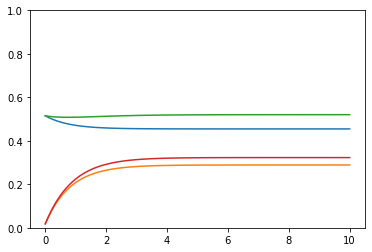

In [116]:
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true, label="True")
plt.plot(t, train, label="Train")
plt.ylim([0,1])
plt.show()

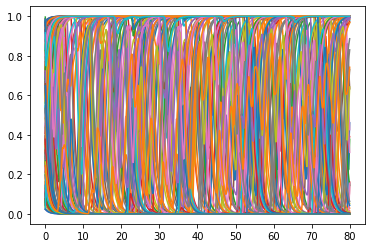

In [117]:
IC = np.random.rand(172)
W = 10*np.random.randn(172, 172)

data = GenerateData(n_data=2000, time=80, IC=IC, W=W, ratio=1)

t = np.linspace(0,80, 1000)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/50 loss 0.466247 pVar -76.857
epoch 1/50 loss 0.462605 pVar -72.995
epoch 2/50 loss 0.463041 pVar -92.175
epoch 3/50 loss 0.456759 pVar -63.999
epoch 4/50 loss 0.451598 pVar -66.402
epoch 5/50 loss 0.447227 pVar -72.966
epoch 6/50 loss 0.426693 pVar -46.959
epoch 7/50 loss 0.422398 pVar -49.898
epoch 8/50 loss 0.419142 pVar -46.317
epoch 9/50 loss 0.419333 pVar -40.199
epoch 10/50 loss 0.417682 pVar -37.497
epoch 11/50 loss 0.414649 pVar -42.362
epoch 12/50 loss 0.411545 pVar -55.917
epoch 13/50 loss 0.409288 pVar -63.501
epoch 14/50 loss 0.407045 pVar -59.860
epoch 15/50 loss 0.407374 pVar -43.029
epoch 16/50 loss 0.403055 pVar -50.431
epoch 17/50 loss 0.406584 pVar -39.855
epoch 18/50 loss 0.405426 pVar -36.962
epoch 19/50 loss 0.404447 pVar -36.853
epoch 20/50 loss 0.402623 pVar -35.444
epoch 21/50 loss 0.399196 pVar -32.814
epoch 22/50 loss 0.392420 pVar -29.246
epoch 23/50 loss 0.391598 pVar -25.579
epoch 24/50 loss 0.388236 pVar -25.526
epoch 25/50 loss 0.385477 pVar -56.

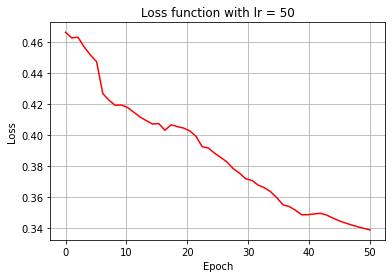

188.01268601417542


In [126]:
import time
start = time.time()
pred = Train_RNN(n_neurons=172, x=data["Data"].T, dt=data["dt"], mu=data["mu"], lr=50, momentum=0.2, g=1, verbose=True, loss_graph=True, n_iters=50)
end = time.time()
print(end-start)

In [127]:
t = np.linspace(0,80,2000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

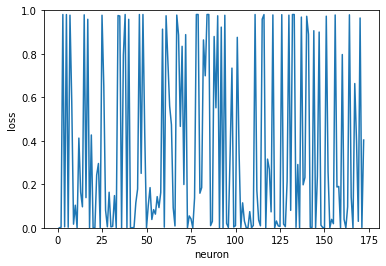

[47, 83, 77]

In [128]:
qual = quality(172, true, train, 3)
qual

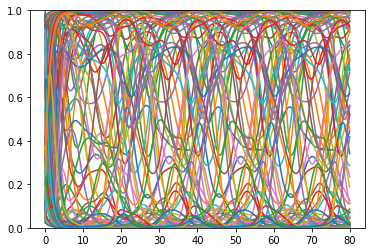

In [129]:
#plt.plot(t, true)
plt.plot(t, train)
plt.ylim([0,1])
plt.show()

**CURBD**

In [66]:
import numpy as np
import pylab
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

ts = np.load('1541_F_dff.npy')
ts = ts[:,0:4000]
print(len(ts))
# Smoothing and z-scoring 
sigma = 60
(N,T) = ts.shape
filtered_ts = np.zeros((N,T))
for i in range(N):
    new_ts = zscore(ts[i,:])
    #new_ts = new_ts-np.min(new_ts)
    new_ts = new_ts/np.max(np.abs(new_ts))
    new_ts = gaussian_filter1d(new_ts, sigma)
    filtered_ts[i,:]= new_ts

172


In [67]:
#(filtered_ts.T[:,1]) gives the 4000 time steps for the neuron #1


new_filter = np.zeros((filtered_ts.shape[0], filtered_ts.shape[1]))

for n in range(172):
    new_filter[n,:] = filtered_ts[n,:] - np.min(filtered_ts[n,:])
    new_filter[n,:] /= np.max(new_filter[n,:])


print(np.min(new_filter))
print(np.max(new_filter))

0.0
1.0


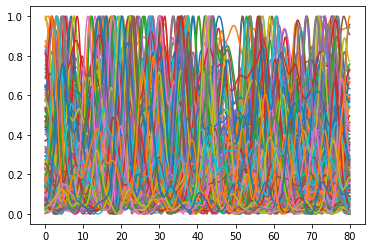

In [68]:
t = np.linspace(0, 80, 4000)
plt.plot(t, new_filter.T[:])
plt.show()

epoch 0/40 loss 0.312870 pVar -44.697
epoch 1/40 loss 0.310087 pVar -42.242
epoch 2/40 loss 0.306483 pVar -26.398
epoch 3/40 loss 0.306686 pVar -24.275
epoch 4/40 loss 0.305812 pVar -22.832
epoch 5/40 loss 0.304660 pVar -21.899
epoch 6/40 loss 0.303564 pVar -21.149
epoch 7/40 loss 0.302609 pVar -20.548
epoch 8/40 loss 0.301606 pVar -20.125
epoch 9/40 loss 0.300638 pVar -19.152
epoch 10/40 loss 0.299504 pVar -18.865
epoch 11/40 loss 0.297412 pVar -18.065
epoch 12/40 loss 0.296478 pVar -18.250
epoch 13/40 loss 0.298548 pVar -25.663
epoch 14/40 loss 0.298622 pVar -32.828
epoch 15/40 loss 0.297817 pVar -31.810
epoch 16/40 loss 0.296689 pVar -30.562
epoch 17/40 loss 0.290977 pVar -16.561
epoch 18/40 loss 0.292686 pVar -20.085
epoch 19/40 loss 0.293997 pVar -28.120
epoch 20/40 loss 0.293225 pVar -27.617
epoch 21/40 loss 0.292310 pVar -27.141
epoch 22/40 loss 0.291228 pVar -26.634
epoch 23/40 loss 0.286706 pVar -17.217
epoch 24/40 loss 0.285105 pVar -15.430
epoch 25/40 loss 0.284263 pVar -15.

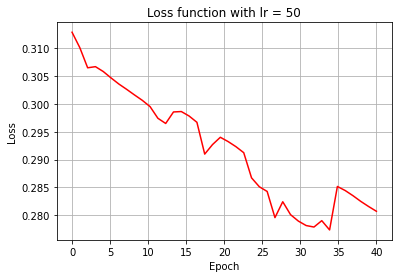

390.2848365306854


In [69]:
import time
start = time.time()
pred = Train_RNN(172, new_filter.T, 0.02, mu=0, lr=50, n_iters=40, verbose=True, loss_graph=True, g=1, momentum=0.2)
end = time.time()
print(end-start)

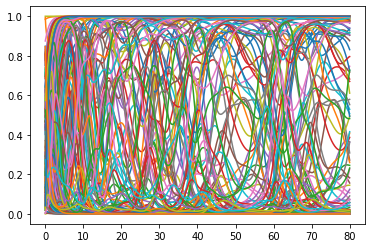

In [70]:
t = np.linspace(0,80,4000)
plt.plot(t, pred["x_pred"])
plt.show()

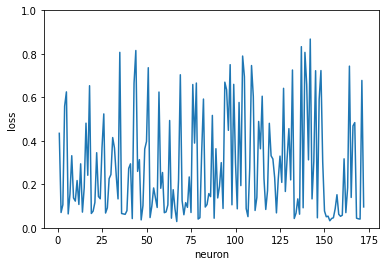

[141, 136, 43, 34, 138]

In [71]:
qual = quality(172, true=pred["x"], train=pred["x_pred"], num_max=5)
qual

-----------------------------

We will now modify our weight at each step.

As you will see, this method is extremly heavy on the computation time. It does not seems to be a viable option for the futur. The fact that we have to retain the graph means that the computation is really heavy.

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, g=1, momentum=0, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''


    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    dt = torch.tensor(dt, dtype=torch.float32)
    mu = torch.tensor(mu, dtype=torch.float32)




    model = RNNModel(W=W, dt=dt, mu=mu)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()


    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC
        #x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        #x_pred[1:] = x_pred_temp.T

        x_pred[1] = model(x[0])  #Find x_pred at time (t+1)

        for i in range(x.shape[0] - 2):

            with torch.no_grad():
                x_pred_temp = x_pred[i+1].clone()
            x_pred[i+2] = model(x_pred_temp)

            #Loss
            l = loss(x[:i], x_pred[:i])

            #Gradient
            l.backward(retain_graph=True)
            
            #update weight matrix
            optimizer.step()
            optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 1 == 0:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l)

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["x"] = x.detach().numpy()
    out["x_pred"] = x_pred.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out

In [9]:
IC = np.random.rand(2)
W = np.random.randn(2,2)

data = GenerateData(100, time=10, IC=IC, W=W, ratio=1)

In [10]:
pred = Train_RNN(n_neurons=2, x=data["Data"].T, dt=data["dt"], mu=data["mu"], lr=1, g=1, momentum=0.2, verbose=True, loss_graph=False, n_iters=50)

epoch 0/50 loss 0.004534 pVar 0.172
epoch 1/50 loss 0.002005 pVar 0.594
epoch 2/50 loss 0.000761 pVar 0.834
epoch 3/50 loss 0.000263 pVar 0.940
epoch 4/50 loss 0.000098 pVar 0.977
epoch 5/50 loss 0.000055 pVar 0.986
epoch 6/50 loss 0.000049 pVar 0.988
epoch 7/50 loss 0.000051 pVar 0.987
epoch 8/50 loss 0.000054 pVar 0.986
epoch 9/50 loss 0.000056 pVar 0.986
epoch 10/50 loss 0.000057 pVar 0.985
epoch 11/50 loss 0.000058 pVar 0.985
epoch 12/50 loss 0.000058 pVar 0.985
epoch 13/50 loss 0.000058 pVar 0.985
epoch 14/50 loss 0.000058 pVar 0.985
epoch 15/50 loss 0.000058 pVar 0.985
epoch 16/50 loss 0.000058 pVar 0.985
epoch 17/50 loss 0.000058 pVar 0.985
epoch 18/50 loss 0.000058 pVar 0.985
epoch 19/50 loss 0.000058 pVar 0.985
epoch 20/50 loss 0.000057 pVar 0.985
epoch 21/50 loss 0.000057 pVar 0.985
epoch 22/50 loss 0.000057 pVar 0.985
epoch 23/50 loss 0.000057 pVar 0.985
epoch 24/50 loss 0.000057 pVar 0.985
epoch 25/50 loss 0.000057 pVar 0.985
epoch 26/50 loss 0.000057 pVar 0.985
epoch 27/50

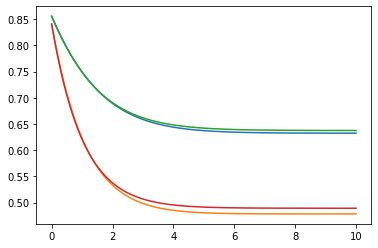

In [11]:
t = np.linspace(0, 10, 500)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true)
plt.plot(t, train)
plt.show()

In [12]:
W = 20*np.random.randn(172, 172)
IC = np.random.rand(172)

data = GenerateData(300, time=30, IC=IC, W=W, ratio=1)



In [13]:
import time
start = time.time()
pred = Train_RNN(n_neurons=172, x=data["Data"].T, dt=data["dt"], mu=data["mu"], lr=10, g=1.1, momentum=0.2, verbose=True, loss_graph=False, n_iters=10)
end = time.time()
print(end-start)

epoch 0/10 loss 0.332969 pVar -5.518
epoch 1/10 loss 0.200271 pVar -9.905
epoch 2/10 loss 0.168205 pVar -16.246
epoch 3/10 loss 0.154464 pVar -13.478
epoch 4/10 loss 0.143610 pVar -19.486
epoch 5/10 loss 0.142335 pVar -19.590
epoch 6/10 loss 0.142223 pVar -20.279
epoch 7/10 loss 0.140992 pVar -17.956
epoch 8/10 loss 0.140350 pVar -19.805
epoch 9/10 loss 0.139247 pVar -21.449
137.1149365901947


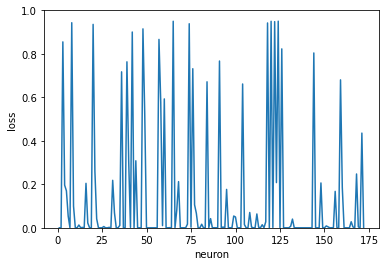

[123, 64, 119]

In [14]:
qual = quality(172, pred["x"], pred["x_pred"], 3)
qual